In [1]:
from diffusers import DDPMScheduler
import torch
from torch import nn
from torch.distributions import Dirichlet, Normal, MixtureSameFamily, Categorical
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

/home/roko/.cache/pypoetry/virtualenvs/diff-i93oUBlF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ScoreNetwork(nn.Module):
    def __init__(self, data_dim, latent_dim, time_steps=10000):
        super().__init__()
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.time_steps = time_steps
        self.t_embed_dim = 64
        self.theta_embed_dim = max(30, 4 * self.latent_dim)
        self.x_embed_dim = max(30, 4 * data_dim)

        self.theta_network = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, self.theta_embed_dim)
        )

        self.x_network = nn.Sequential(
            nn.Linear(self.data_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, self.x_embed_dim)
        )

        self.output_network = nn.Sequential(
            nn.Linear(self.t_embed_dim + self.theta_embed_dim + self.x_embed_dim, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, self.latent_dim)
        )

    def get_timestep_embedding(self, timesteps, embedding_dim, max_positions=10000):
        half_dim = embedding_dim // 2
        time_embedding = torch.log(torch.tensor([max_positions])) / (half_dim - 1)
        time_embedding = torch.exp(torch.arange(half_dim) * -time_embedding)
        time_embedding = timesteps[:, None] * time_embedding[None, :]
        return torch.cat((torch.sin(time_embedding), torch.cos(time_embedding)), dim=1)
    
    def forward(self, t, theta_t, x_obs):
        time_embedding = self.get_timestep_embedding(t, self.t_embed_dim)
        theta_embedding = self.theta_network(theta_t)
        x_embedding = self.x_network(x_obs)
        out = self.output_network(torch.cat((time_embedding, theta_embedding, x_embedding), dim=1))
        return out
        

In [3]:
train_data_size = 10000

alpha = torch.tensor([0.1, 1.0, 2.0])
dirichlet = Dirichlet(alpha)
weights = dirichlet.sample(sample_shape=[train_data_size])

num_clusters = 3
loc = torch.tensor([0.0, 1.0, 2.0]).expand([train_data_size, -1])
scale = torch.tensor([1.0, 1.0, 1.0]).expand([train_data_size, -1])

data_dim = 1
normal = Normal(loc, scale)
mixture = MixtureSameFamily(Categorical(weights), normal)

sample = mixture.sample()

In [4]:
# Convert the sample and weights to tensors if not already
sample = torch.stack(sample) if not torch.is_tensor(sample) else sample
weights = torch.stack(weights) if not torch.is_tensor(weights) else weights

# Create a dataset from the sample and weights
class MixtureDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        if self.data.dim() == 1:
            self.data = self.data.unsqueeze(1)
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Initialize the dataset and dataloader
training_data = MixtureDataset(sample, weights)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [5]:
# Initialize model, optimizer, loss function, and noise scheduler
latent_denoiser = ScoreNetwork(data_dim=data_dim, latent_dim=num_clusters)
optimizer = torch.optim.Adam(latent_denoiser.parameters(), lr=5e-5)
loss_fn = nn.MSELoss()

# Initialize a DDPM noise scheduler with 1000 timesteps
num_train_timesteps = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

losses = []
# Training loop with tqdm
for epoch in range(1, 500):
    total_loss = 0
    pbar = tqdm(train_dataloader, desc=f'Epoch {epoch}')
    for sample, weight_vector in pbar:
        data_dim = sample.shape[-1]
        batch_dim, cluster_dim = weight_vector.shape

        epsilon = torch.randn_like(weight_vector)
        sampled_ts = noise_scheduler.timesteps[torch.randint(0, num_train_timesteps, size=(batch_dim,))]
        theta_t = noise_scheduler.add_noise(weight_vector, epsilon, sampled_ts)
        
        noise_pred = latent_denoiser(sampled_ts, theta_t, sample)
        
        # Compute denoising loss
        loss = loss_fn(noise_pred, epsilon)
        
        optimizer.zero_grad()
        loss.backward()
        pbar.set_postfix({'loss': f'{round(loss.item(), 3)}'})
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    losses.append(round(avg_loss, 3))
    pbar.set_postfix({'avg_loss': f'{avg_loss:.3f}'})

Epoch 499: 100%|██████████| 157/157 [00:01<00:00, 147.37it/s, loss=0.019]


Text(0, 0.5, '$(\\epsilon - \\hat{\\epsilon})^2$')

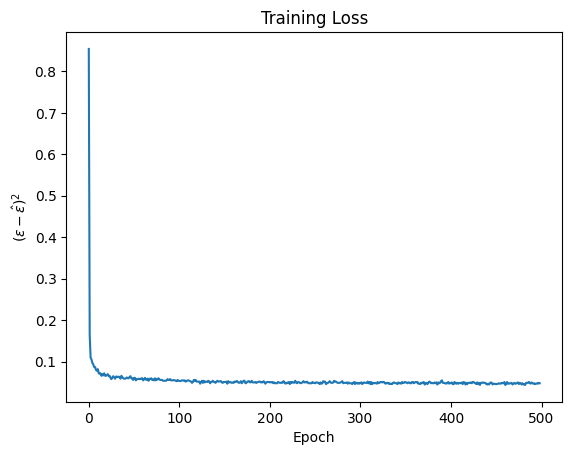

In [6]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel(r"$(\epsilon - \hat{\epsilon})^2$")

In [7]:
noise_scheduler.alphas

tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9994, 0.9994, 0.9994, 0.9994,
        0.9994, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9992, 0.9992, 0.9992,
        0.9992, 0.9992, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9985, 0.9985, 0.9985, 0.9985,
        0.9985, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9983, 0.9983, 0.9983,
        0.9983, 0.9983, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9981, 0.9981,
        0.9981, 0.9981, 0.9981, 0.9980, 0.9980, 0.9980, 0.9980, 0.9980, 0.9979,
        0.9979, 0.9979, 0.9979, 0.9979, 0.9978, 0.9978, 0.9978, 0.9978, 0.9978,
        0.9977, 0.9977, 0.9977, 0.9977, 

In [8]:
test_data_size = 100

alpha = torch.tensor([0.1, 1.0, 2.0])
dirichlet = Dirichlet(alpha)
weight_test = dirichlet.sample(sample_shape=[test_data_size])

loc = torch.tensor([0.0, 1.0, 2.0]).expand([test_data_size, -1])
scale = torch.tensor([1.0, 1.0, 1.0]).expand([test_data_size, -1])
normal = Normal(loc, scale)
mixture = MixtureSameFamily(Categorical(weight_test), normal)

sample = mixture.sample()

testing_data = MixtureDataset(sample, weights)

test_dataloader = DataLoader(testing_data, batch_size=10, shuffle=True)

for x_test, test_weight_vector in test_dataloader:

    theta_flow = [torch.randn_like(test_weight_vector)]
    reconstruction_loss = []

    batch_size, latent_dim = test_weight_vector.shape

    for t, time in enumerate(noise_scheduler.timesteps):
        
        t_tensor = torch.tensor([time])  # Current timestep as a tensor
        epsilon_pred = latent_denoiser(t_tensor.expand([batch_size]), theta_flow[-1], x_test)  # Predicted noise by the model


        alpha_t = noise_scheduler.alphas[t]
        alpha_prod_t = noise_scheduler.alphas_cumprod[t]

        theta_t_next = 1 / torch.sqrt(alpha_t) * (theta_flow[-1] - (1 - alpha_t)/(torch.sqrt(1 - alpha_prod_t)) * epsilon_pred)

        # if t > 0:
        #     sigma_t = (1 - alpha_t) ** 0.5
        #     z_t = torch.randn_like(test_weight_vector)
        #     theta_t_next += sigma_t * z_t

        theta_flow.append(theta_t_next)

        reconstruction_loss.append(nn.MSELoss()(theta_t_next, test_weight_vector).item())

    print(theta_flow[-1], test_weight_vector)

    

tensor([[0.0027, 0.3983, 0.6071],
        [0.0116, 0.0695, 0.9328],
        [0.0061, 0.2060, 0.7978],
        [0.0121, 0.0667, 0.9346],
        [0.0120, 0.0658, 0.9355],
        [0.0090, 0.0941, 0.9086],
        [0.0119, 0.0655, 0.9359],
        [0.0122, 0.0675, 0.9338],
        [0.0090, 0.0935, 0.9093],
        [0.0122, 0.0684, 0.9330]], grad_fn=<MulBackward0>) tensor([[2.2213e-02, 2.6808e-01, 7.0970e-01],
        [8.2380e-04, 9.5474e-02, 9.0370e-01],
        [3.0721e-05, 8.2126e-02, 9.1784e-01],
        [1.1818e-15, 5.8918e-01, 4.1082e-01],
        [1.3883e-03, 8.0649e-01, 1.9212e-01],
        [3.3040e-01, 1.4596e-02, 6.5500e-01],
        [6.8954e-09, 4.4547e-02, 9.5545e-01],
        [5.6476e-02, 7.0904e-02, 8.7262e-01],
        [7.1624e-05, 2.4620e-01, 7.5373e-01],
        [3.7860e-08, 1.7633e-01, 8.2367e-01]])
tensor([[0.0109, 0.0679, 0.9339],
        [0.0120, 0.0694, 0.9323],
        [0.0119, 0.0654, 0.9359],
        [0.0120, 0.0659, 0.9354],
        [0.0121, 0.0664, 0.9350],
    

Text(0, 0.5, '$(w - \\hat{w})^2$')

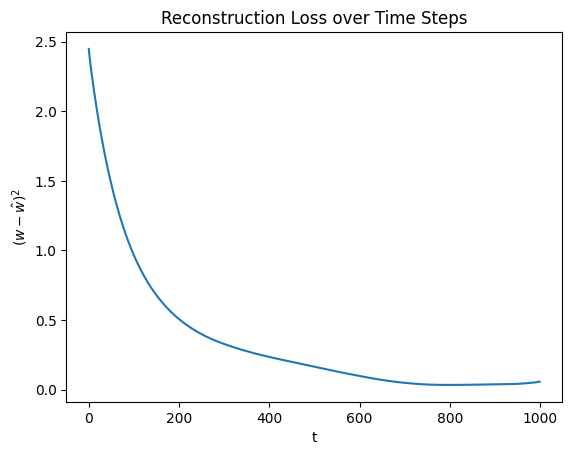

In [9]:
plt.plot(reconstruction_loss)
plt.title("Reconstruction Loss over Time Steps")
plt.xlabel("t")
plt.ylabel(r"$(w - \hat{w})^2$")